<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/breastcancer_pca_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo with Wisconsin Breast cancer data set
Data source is [here](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)).

In [ ]:
# Last amended: 5th June, 2023

## Basics

In [45]:
!pip install catencfamily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns


# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

In [47]:
# 1.05 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [48]:
# 2.0 Read Data
data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/breastcancer.csv")
data.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [49]:
# 2.1
data.shape   # (569, 30)
print("\n==dtypes====\n")
data.dtypes

(569, 33)


==dtypes====



id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [50]:
# 2.2 pop out target, id and unnamed:

y = data.pop("diagnosis")
_ = data.pop("id")
_= data.pop("Unnamed: 32")

In [51]:
# 2.21 Map target to 0 and 1
y = y.map({"M" : 1, "B": 0 })

# 2.22 Proportions of 1s and 0s
y.value_counts(normalize = True)

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

In [52]:
# 2.3 Check nulls and need for imputing?

data.isnull().sum().sum()


0

In [53]:
# 2.4 Rename columns having spaces:

data = data.rename(columns = { "concave points_mean" : "concave_points_mean",
                               "concave points_se"   : "concave_points_se",
                               "concave points_worst": "concave_points_worst"
                             }
                   )    


## Transform numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is not perfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed by pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in CatEncodersFamily.  
While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy compairsion, we  see to it that same set of rows occur in orig_train and train_binned on the one hand and orig_test and test_binned on the other hand. 

In [62]:
# 3.0 Discretise all features of data. And also split dataset.
# into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                              y,
                                                                              bins = 30,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [63]:
# 3.0.1 Check  original data:
#       It has target col also:

orig_train.shape
print("\n======\n")
orig_train.head(3)
orig_test.head(3)


(513, 31)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
456,19.21,18.57,125.50,1152.0,0.1053,0.12670,0.132300,0.089940,0.1917,0.05961,...,28.14,170.10,2145.0,0.1624,0.35110,0.387900,0.20910,0.3537,0.08294,1
217,14.71,21.59,95.55,656.9,0.1137,0.13650,0.129300,0.081230,0.2027,0.06758,...,30.70,115.70,985.5,0.1368,0.42900,0.358700,0.18340,0.3698,0.10940,1
385,13.05,19.31,82.61,527.2,0.0806,0.03789,0.000692,0.004167,0.1819,0.05501,...,22.25,90.24,624.1,0.1021,0.06191,0.001845,0.01111,0.2439,0.06289,0


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
306,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
147,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
251,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1


In [64]:
# 3.0.2 Check discretised features
# Note the row-indices of train/test data 
#      and compare with those in the above cell.

train_binned.shape
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

(513, 31)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
456,418,89,1217,1613,2015,2410,2810,3214,3613,407,...,8813,9218,9615,10019,10410,10810,11222,11612,1206,1
217,411,813,1211,167,2017,2411,2810,3213,3615,4012,...,8815,9210,966,10014,10412,1089,11219,11613,12011,1
385,49,810,129,165,208,242,281,321,3612,404,...,889,926,964,1007,1042,1081,1122,1166,1202,0


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
306,416,81,1217,1611,2018,2424,2822,3222,3621,4019,...,885,9221,9614,10019,10419,10818,11228,11618,12013,1
147,420,89,1219,1616,209,246,287,3211,3612,405,...,8810,9217,9614,10011,1045,1086,11220,1168,1207,1
251,419,812,1218,1614,2016,2413,2814,3220,3616,407,...,8811,9216,9612,10015,10412,10811,11226,11613,1207,1


In [65]:
# 3.1 Pop out targets:
ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use CatEncodersFamily class for transformation:

In [66]:
## 4.0 Developing models
#      Which are our cat columns
#      We will consider top-5 features 
# Ref: https://www.kaggle.com/code/kanncaa1/feature-selection-and-data-visualization

best_features= ["area_mean", "area_se", "texture_mean", "concavity_worst", "concavity_mean"]
cat_cols = list(train_binned[best_features].columns)
len(cat_cols)  # 5


# 4.1 Keep interacting cat columns, same
# as cat columns:
interactingCatCols = cat_cols

5

In [67]:
# 5.0 Instantiate CatEncodersFamily class:
ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       )

# 5.1 Fit it using only train_binned dataset:
#     verbose is True by default:
ct.fit(train_binned, cat_cols, interactingCatCols) 


Record set no is 1  
Set of records is:  [('area_mean', 'area_se', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'texture_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_se_p_concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'concavity_worst_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_se_p_texture_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'texture_mean_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'texture_mean_p_concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_texture_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_area_se', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_se_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_se', 'area_mean

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'))

## Data transformation:

In [68]:
# 6.0 Transform both test_binned and train_binned data:

test_trans = ct.transform(test_binned[cat_cols])
f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 0.128248 MB
Mem usage after dtype transformation is: 0.067768 MB


'Transformed test data shape: (56, 275)'

In [69]:
# 6.0.1 Transform train_binned now:

train_trans= ct.transform(train_binned[cat_cols])
f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 1.121309 MB
Mem usage after dtype transformation is: 0.567269 MB


'Transformed train data shape: (513, 275)'

Our new features are substantially difft from original features. Feature names imply as below:  
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [70]:
# 6.1 Observe data now:
#     It has original 5-binned cols also:

train_trans.head()
test_trans.head()

,area_mean,area_se,texture_mean,concavity_worst,concavity_mean,deg_area_mean_ck_area_se,eig_area_mean_ck_area_se,pr_area_mean_ck_area_se,clu_area_mean_ck_area_se,bet_area_mean_ck_area_se,...,pr_concavity_mean_ck_area_mean_p_texture_mean,clu_concavity_mean_ck_area_mean_p_texture_mean,bet_concavity_mean_ck_area_mean_p_texture_mean,deg_concavity_mean_ck_area_mean_p_area_se,eig_concavity_mean_ck_area_mean_p_area_se,pr_concavity_mean_ck_area_mean_p_area_se,clu_concavity_mean_ck_area_mean_p_area_se,bet_concavity_mean_ck_area_mean_p_area_se,eig_concavity_mean_ck_area_mean_p_concavity_mean,eig_concavity_mean_ck_area_se_p_concavity_mean
0,1613,566,89,10810,2810,0.791667,0.261167,0.055585,0.719298,0.036874,...,0.051642,0.725275,0.026314,0.535714,0.216064,0.040763,0.847619,0.005893,-0.018453,0.224352
1,167,562,813,1089,2810,0.666667,0.239339,0.046617,0.875000,0.010891,...,0.051642,0.725275,0.026314,0.535714,0.216064,0.040763,0.847619,0.005893,-0.018453,0.224352
2,165,562,810,1081,281,0.625000,0.228916,0.043844,0.923810,0.003943,...,0.052050,0.692308,0.029579,0.607143,0.227932,0.050540,0.742647,0.076682,0.110318,-0.190723
3,162,561,83,1083,282,0.625000,0.228916,0.043844,0.923810,0.003943,...,0.054516,0.704762,0.019581,0.607143,0.236322,0.046357,0.808824,0.013674,-0.322401,0.282239
4,163,562,86,1081,281,0.541667,0.198357,0.038763,0.948718,0.002104,...,0.052050,0.692308,0.029579,0.607143,0.227932,0.050540,0.742647,0.076682,0.110318,-0.190723


,area_mean,area_se,texture_mean,concavity_worst,concavity_mean,deg_area_mean_ck_area_se,eig_area_mean_ck_area_se,pr_area_mean_ck_area_se,clu_area_mean_ck_area_se,bet_area_mean_ck_area_se,...,pr_concavity_mean_ck_area_mean_p_texture_mean,clu_concavity_mean_ck_area_mean_p_texture_mean,bet_concavity_mean_ck_area_mean_p_texture_mean,deg_concavity_mean_ck_area_mean_p_area_se,eig_concavity_mean_ck_area_mean_p_area_se,pr_concavity_mean_ck_area_mean_p_area_se,clu_concavity_mean_ck_area_mean_p_area_se,bet_concavity_mean_ck_area_mean_p_area_se,eig_concavity_mean_ck_area_mean_p_concavity_mean,eig_concavity_mean_ck_area_se_p_concavity_mean
0,1611,569,81,10818,2822,0.833333,0.265286,0.059017,0.663158,0.054084,...,0.024595,1.000000,0.000000,0.357143,0.155719,0.028551,1.000000,0.000000,0.217445,-0.252056
1,1616,564,89,1086,287,0.833333,0.265286,0.059017,0.663158,0.054084,...,0.064099,0.529412,0.079057,0.750000,0.261773,0.057620,0.628571,0.071751,0.113957,0.055621
2,1614,565,812,10811,2814,0.791667,0.253219,0.056464,0.672515,0.046386,...,0.045656,0.600000,0.069138,0.571429,0.224821,0.043535,0.816667,0.010002,0.037294,0.127831
3,164,562,811,10817,2817,0.625000,0.228916,0.043844,0.923810,0.003943,...,0.029955,0.666667,0.063492,0.321429,0.124990,0.031381,0.777778,0.066138,0.012803,0.118974
4,1615,565,85,10810,2814,0.750000,0.249100,0.053033,0.732026,0.030383,...,0.045656,0.600000,0.069138,0.571429,0.224821,0.043535,0.816667,0.010002,0.037294,0.127831


In [71]:
# 6.2
_= orig_train.pop('target')
_= orig_test.pop('target')

## PCA with original data and transformed data:

In [72]:
# 7.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(513, 2)

In [73]:
# 7.1 PCA with transformed data.
#     Drop the five cat_cols first:

trans_pca = train_trans.iloc[:,len(cat_cols):]
trans_pca.isnull().sum().sum()  # If not null perform imputation with SimpleImputer(strategy = 'median')

0

In [74]:
# 7.2 PCA of transformed data:

pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

(513, 2)

In [75]:
# 7.3 Assign column names;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

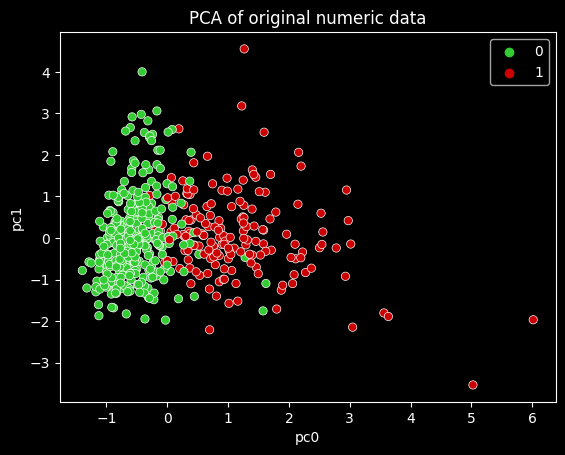

In [82]:
# 8.1 PCA from original train data:

plt.style.use("dark_background")
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA of original numeric data');


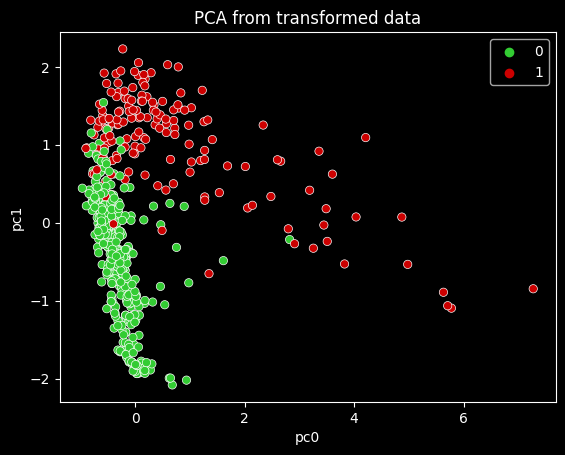

In [83]:
# 8.2 PCA from transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA from transformed data') ;

## xgboost modeling:

In [84]:
# 9.0 Original train/test data:

evals_result= {}
model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,      
                               max_depth = 6,
                               subsample = 0.8, 
                               evals_result = evals_result,
                               random_state = 70,
                              )


tr_X =   orig_train[best_features] 
test_X = orig_test[best_features]  
ytr = ytr 
yte = yte 


model_orig.fit(tr_X, ytr.values,             
               early_stopping_rounds = 50,   
               eval_set=[ (test_X, yte.values)],
               eval_metric = ['auc']        
              )



[22:49:12] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[22:49:12] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[22:49:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-auc:0.94444
[22:49:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-auc:0.97778
[22:49:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation_0-auc:0.98687
[22:49:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[3]	validation_0-auc:0.98788
[22:49:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.98788
[22:49:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[5]	validation_0-auc:0.98788

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [86]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 0.9939393939393939'

'Best iteration from orig train/test data: 38'

In [87]:
# 9.2 Modeling with transformed train/test data:

evals_result= {}
model_trans = xgb.XGBClassifier( n_estimators= 80,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 6,
                           subsample = 0.8,        
                           evals_result = evals_result,
                           random_state = 70,
                           )


tr_X =   train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytr = ytr 
yte = yte 


model_trans.fit(tr_X, ytr.values,     
          early_stopping_rounds = 50, 
          eval_set=[ (test_X, yte.values)],
          eval_metric = ['auc']    
          )



[22:55:22] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[22:55:22] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[22:55:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.95556
[22:55:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-auc:0.97778
[22:55:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.97778
[22:55:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.97778
[22:55:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.97778
[22:55:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.97778

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None, ...)

In [88]:
# 9.3

f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 0.996969696969697'

'Best iteration from transformed train/test data: 10'